# Дискретно-событийное моделирование

Рассмотрим, как устроено дискретно-событийное моделирование (ДСМ) в Python в контексте библиотеки [SimPy](https://simpy.readthedocs.io/en/latest/index.html), реализующей **всё, что только может понадобиться для этого**.

Начнём с простой и показательной задачки о движении абсолютно упругого шарика в ограниченном двумерном пространстве (коробке).
Затем подробнее рассмотрим некоторые примеры из документации SimPy.

## Шарик в коробке

Представьте прямоугольную коробку, внутри которой от стенки к стенке движется абсолютно упругий шарик.
Когда он достигает границы области, то упруго от неё отскакивает.
Пусть пространство будет ограничено прямоугольником шириной $w$ и высотой $h$.
Шарик в начальный момент времени $t_0 = 0$ находится в случайной точке $(x_0, y_0)$ внутри прямоугольника и имеет случайную скорость $(v_x, v_y)$ постоянную по величине: $v = \sqrt{v_x^2 + v_y^2} = \mathrm{const}$.

При абсолютно упругом ударе о вертикальные стенки отражается _x_-составляющая скорости $v_x' = -v_x$, при ударе о горизонтальные - _y_-составляющая: $v_y' = -v_y$.

Мы хотим промоделировать движение шарика в коробке в течение заданного времени $T$.
Как это сделать?

Одно из решений, часто первым приходящим на ум, заключается в задании некоторого **постоянного** _малого_ шага по времени $\Delta t$.
Однако сразу возникает две проблемы:

1. Как определить, какой шаг является _малым_, а какой - _большим_?
2. Постоянная величина шага $\Delta t$ приводит к проблеме _пересечения границ_, т.е. тело выходит за границы расчётной области и на деле ударяется не о стенку коробки, а о _что-то_, расположенное вне её.
   Это кардинально меняет траекторию тела, по сути нарушая задачу.

Шаг по времени в данной задачи зависит от размеров прямоугольника и скорости тела.
Чем меньше область и больше скорость, тем меньше должен быть шаг $\Delta t$.
Скажем, при скорости 1 м/с и шаге по времени 0.1 с шарик выйдет за границу не более, чем на $1 \cdot 0.5 = 0.1$ м.
Если размеры прямоугольника составляют десятки и более метров, то погрешность в 0.1 м не велика.
Однако тогда понадобится очень большое число промежуточных шагов, при которых никаких _событий_ (столкновений) в системе не происходит.
**Компьютер тратит время впустую** (и мы вместе с ним).
Более того, ошибка в расчёте столкновений всё же присутствует, сколь малой бы она ни была.
Если за время моделирования шарик столкнётся со стенками 10 раз - мы получим одну величину ошибки $\varepsilon_1$ в определении конечного положения тела.
Если же столкновений будет 100000, то ошибка $\varepsilon_2$ конечного положения будет много больше ошибки $\varepsilon_1$.
Следовательно, при итеративном подходе **ошибка накапливается**.
Ошибка накапливается также ввиду конечной точности чисел с плавающей точкой в компьютере.

Рассмотренный подход называется _итеративным_.
Каждая итерация представляет из себя следующую последовательность действий:

* $x_{i+1} = x_i + v_{x\, i+1} \Delta t_i$;
* $y_{i+1} = y_i + v_{y\, i+1} \Delta t_i$;
* $t_{i+1} = t_i + \Delta t_i$;
* проверка пересечения границ.
  Если границы пересечены, то меняется знак соответствующей проекции скорости.
  Например, при столкновении с правой или левой стенкой $v_{x\, i+1} = -v_{xi}$.
  Если столкновения нет, то проекции не изменяются: $v_{x\, i+1} = v_{xi}$ и $v_{y\, i+1} = v_{yi}$;
* итерации повторяются, пока $t_i < T$.

Проверка пересечения границ заключается в проверке условий
$x \notin (x_\mathrm{lb}; x_\mathrm{rb})$ и
$y \notin (y_\mathrm{bb}; y_\mathrm{tb})$,
где
$x_\mathrm{lb}$ и $x_\mathrm{rb}$ - прямые левой и правой границ соответственно;
$y_\mathrm{bb}$ и $y_\mathrm{tb}$ - прямые нижней и верхней границ соответственно.

Если не спешить и обдумать задачу более основательно, то можно заметить, что по известной и постоянной скорости, начальному положению тела и при известных размерах пространства несложно _рассчитать_ промежуток времени $\Delta t_i$, через который тело столкнётся с одной из границ.
Действительно, если в момент времени $t_i$ проекции скорости тела $v_{xi} > 0$ и $v_{yi} > 0$, то шарик движется в направлении правой и верхней стенок.
Остаётся определить, которая из них будет достигнута быстрее.
Если координата шарика в момент времени $t_i$ есть $(x_i, y_i)$, то с правой границей он столкнётся через время $\Delta t_{\mathrm{rb} i} = (x_\mathrm{rb} - x_i) / v_{xi}$, а с верхней - через $\Delta t_{\mathrm{tb} i} = (y_\mathrm{tb} - y_i) / v_{yi}$.
И тогда $t_{i+1} = t_i + \min(\Delta t_{\mathrm{rb} i}, \Delta t_{\mathrm{tb} i})$.
Аналогично рассчитывается время столкновения с любой границей в зависимости от комбинации знаков проекций скорости тела.

```{note}
Если какая-либо из проекций равна нулю, то достаточно рассмотреть лишь одну границу, в направлении которой движется тело.
```

Таким образом, мы можем рассчитать момент времени $t_{i+1} = t_{i} + \Delta t_i$ наступления $(i+1)$-го _события_ "столкновение со стенкой".
Зная $\Delta t_i$, мы можем **точно рассчитать** точку столкновения с границей: $x_{i+1} = x_i + v_{xi} \Delta t_i$ и $y_{i+1} = y_i + v_{yi}\Delta t_i$, после чего изменить знак соответствующей проекции скорости: либо $v_{x\, i+1} = -v_{xi}$, либо $v_{y\, i+1} = -v_{yi}$.
После этого рассчитывается время до следующего столкновения и т.д.

При этом нам **не нужно**

* думать о выборе шага по времени, зависящего от нескольких параметров (в реальных задачах таких параметров может быть гораздо больше, чем в рассматриваемой задаче);
* впустую тратить расчётное время компьютера - он считает лишь моменты, в которых меняется _состояние системы_ (в данном случае, когда при столкновении меняется знак у одной из проекций скорости);
* знать сколько раз за время моделирования шарик столкнётся со стенками.

При применении ДСМ также **не накапливается ошибка** численного расчёта.
Получается траектория движения шарика, совпадающая с теоретической.

```{important}
Состояние системы изменяется при наступлении какого-либо события.
Между событиями состояние остаётся постоянным.
Это одно из основных положений ДСМ.
```

Реализуем сначала итеративный подход.
Получим траекторию тела, которую затем сравним с траекторией, полученной с применением ДСМ.

### Итеративный подход

Напишем функцию итеративного решения задачи о шарике в коробке.
Назовём её `iterative_solver`.
Чтобы было легче воспринимать код, разобьём его на более мелкие составные части (функции).

Начнём с реализации вспомогательной функции определения столкновений с границами.
Условия столкновения, как отмечено выше, следующие:

$$
x_i \notin (x_\mathrm{lb}; x_\mathrm{rb}), \quad
y_i \notin (y_\mathrm{bb}; y_\mathrm{tb}).
$$

In [19]:
def collision(bounds, p):
    """Условие столкновения шара с границами коробки.

    * `bounds` - кортеж вида `(x_lb, x_rb, y_bb, y_tb)`,
      хранящий координаты левой, правой, нижней и верхней границ
      прямоугольной области.
    * `p` - текущая координата `(x, y)` шара.
    
    Возвращает кортеж из двух значений, определяющих, нужно ли
    инвертировать соответствующую проекцию скорости.
    """
    x_lb, x_rb, y_bb, y_tb = bounds
    x, y = p
    # Знак элемента signs показывает, нужно ли инвертировать
    # соответствующую проекцию скорости
    flag = False    # Было ли столкновение
    signs = [1, 1]
    if not x_lb < x < x_rb:
        # Столкновение с одной из вертикальных стен,
        # значит, нужно инвертировать v_x
        signs[0] = -1
        flag = True
    if not y_bb < y < y_tb:
        # Столкновение с одной из горизонтальных стен,
        # значит, нужно инвертировать v_y
        signs[1] = -1
        flag = True
    return flag, signs

```{warning}
Функция `collision` имеет один эффект, влияющий на траекторию шара, который мы не предусмотрели.
Получится ли у вас его определить?
```

Теперь сама функция итеративного решателя:

In [20]:
import numpy as np

def iterative_solver(bounds, p, v, t_until, t_step):
    """Итеративный решатель задачи о шарике в коробке.
    
    * `bounds` - кортеж из 4 чисел вида `(x_lb, x_rb, y_bb, y_tb)`,
      описывающий левую, правую, нижнюю и верхнюю границы
      прямоугольной области.
    * `p` - начальная координата шара `(x, y)`.
    * `v` - кортеж `(v_x, v_y)` со значениями проекций вектора
       начальной скорости шара.
    * `t_until` - время моделирования.
    * `t_step` - постоянный шаг по времени.
    """
    # Распакуем аргументы-кортежи в соответствующие переменные
    x, y = p
    v_x, v_y = v
    # Инициализируем "часы"
    t = 0
    # и массив траекторных точек
    # (именно эти три переменные формируют траекторию)
    traj = [(t, x, y)]
    # Выполняем итерации:
    while t <= t_until:
        # 1. Обновляем координаты и время
        x += v_x * t_step
        y += v_y * t_step
        t += t_step
        # 2. Проверяем условие столкновения
        flag, (svx, svy) = collision(bounds, (x, y))
        # 3. Инвертируем проекции скорости
        #    (если svx и svy отрицательны)
        if flag:
            # Просто чтобы не расходавать память
            # на точки между столкновениями
            traj.append((t, x, y))
            v_x *= svx
            v_y *= svy
    # В завершение добавим последнюю точку траектории
    traj.append((t, x, y))
    # Возвращаем полученную траекторию
    # в виде массива NumPy
    return np.array(traj)

Напишем удобную для многоразового использования функцию визуализации траектории `plot_traj`:

In [21]:
import matplotlib.pyplot as plt

def plot_traj(traj, figax=None, **kw):
    """Строит траекторию тела."""
    if figax is None:
        fig, ax = plt.subplots()
    else:
        fig, ax = figax
    # Линии траектории
    ax.plot(traj[:, 1], traj[:, 2], **kw)
    # Начальная и конечная точки
    ax.plot(traj[0, 1], traj[0, 2],
            ls="", marker="o", c="purple")
    ax.plot(traj[-1, 1], traj[-1, 2],
            ls="", marker="x", c="purple")
    return fig, ax

Посмотрим, что получилось.
Пусть условия задачи таковы:

* $x_\mathrm{lb} = 0$, $x_\mathrm{rb} = 1$, $y_\mathrm{bb} = 0$ и $y_\mathrm{tb} = 1$ м;
* $x_0 = 0.67$ и $y_0 = 0.33$ м;
* $v_{x0} = 0.3$ и $v_{y0} = 0.1$ м/с;
* шаг по времени $\Delta t = 0.5$ с;
* время моделирования $T = 60$ с.

In [22]:
# Условия задачи
bounds = 0, 1, 0, 1
xy = 0.67, 0.33
v = 0.3, 0.1
dt = 0.5
t_until = 60

Моделируем и строим траекторию:

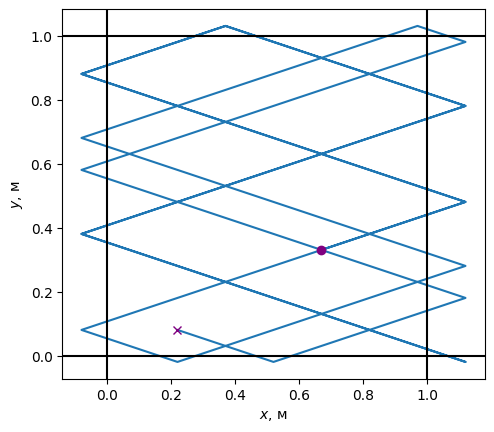

In [23]:
traj = iterative_solver(bounds, xy, v, t_until, dt)
_, ax = plot_traj(traj)
ax.axvline(bounds[0], color="k")
ax.axvline(bounds[1], color="k")
ax.axhline(bounds[2], color="k")
ax.axhline(bounds[3], color="k")
ax.set(xlabel="$x$, м", ylabel="$y$, м", aspect="equal");

Число столкновений:

In [24]:
print("Число столкновений:", traj.shape[0] - 1)
# Не учитывая последнюю (свободную) точку

Число столкновений: 21


```{note}
Кстати, о непредусмотренном эффекте функции `collision`.
Этот эффект виден на получившемся графике.
```

Если уменьшить шаг по времени в 5 раз, то получим следующую картину:

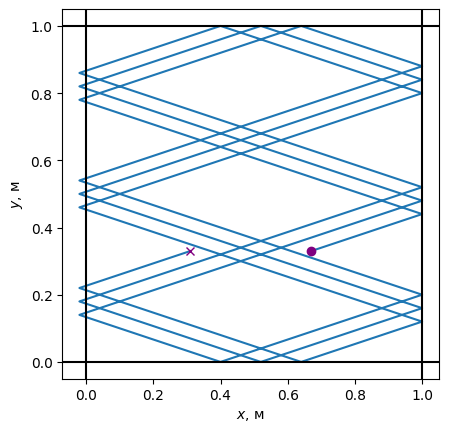

In [25]:
traj_iterative = iterative_solver(
    bounds, xy, v, t_until, t_step=dt/5
)
_, ax = plot_traj(traj_iterative)
ax.axvline(bounds[0], color="k")
ax.axvline(bounds[1], color="k")
ax.axhline(bounds[2], color="k")
ax.axhline(bounds[3], color="k")
ax.set(xlabel="$x$, м", ylabel="$y$, м", aspect="equal");

In [26]:
print("Число столкновений:", traj_iterative.shape[0] - 1)

Число столкновений: 25


Сравнив два рисунка, можно заметить, что хоть уменьшение шага и привело к более точной траектории тела, но пересечение границ всё равно присутствует.
Также при различном временном шаге получены разные значения числа столкновений - 21 и 25 соответственно.

```{note}
Заметьте, что столкновение с горизонтальными границами происходит _почти_ на них.
На самом деле при данном масштабе не видно, что выход за границу по вертикальной оси составляет 0.03 м.
Можно и так подобрать параметры задачи (шаг по времени, скорость и начальную координату шара), что столкновение будет происходить точно на границах.
Но это будет либо совпадением, либо подгонкой параметров, которую бывает невозможно произвести в сложных задачах.
```

Настало время решить эту задачу правильно.

### Дискретно-событийный подход

Как отмечено выше, при дискретно-событийном подходе мы должны рассчитать момент наступления события.
Для этой цели опишем функцию `calc_delay`, которая по заданным границам, скорости $(v_{xi}, v_{yi})$ и положению тела $(x_i, y_i)$ рассчитает, через какое время $\Delta t_i$ наступит следующее событие:

In [27]:
def calc_delay(bounds, v, p):
    """Рассчитать задержку времени перед следующим событием
    при заданных границах `bounds = (x_lb, x_rb, y_bb, y_tb)`,
    скорости шара `v = (v_x, v_y)` и координате его последнего
    столкновения `p = (x, y)`."""
    # Распакуем аргументы для удобства
    x_lb, x_rb, y_bb, y_tb = bounds
    x, y = p
    vx, vy = v
    # Вычисляем время (задержку)
    dtx, dty = 0., 0.
    # - в направлении оси Ox
    if vx > 0:
        dtx = (x_rb - x) / vx
    elif vx < 0:
        dtx = (x_lb - x) / vx
    # - в направление оси Oy
    if vy > 0:
        dty = (y_tb - y) / vy
    elif vy < 0:
        dty = (y_bb - y) / vy
    # Определение, какую проекцию скорости инвертировать
    signs = [1, 1]
    signs[np.argmin((dtx, dty))] = -1
    return min(dtx, dty), signs

Реализуем решатель `de_solver`:

In [28]:
import simpy as sim

def de_solver(bounds, p, v, t_until):
    p, v = np.array(p), np.array(v)
    env = sim.Environment()
    traj = [(env.now, *p)]
    env.process(loop(env, bounds, p, v, traj))
    env.run(t_until)
    p += v * (t_until - traj[-1][0])
    traj.append((env.now, *p))
    return np.array(traj)

def loop(env, bounds, p, v, traj):
    while True:
        dt, signs = calc_delay(bounds, v, p)
        yield env.timeout(dt)
        p += v * dt
        traj.append((env.now, *p))
        v *= signs

Промоделируем при тех же исходных параметрах:

Число столкновений: 25


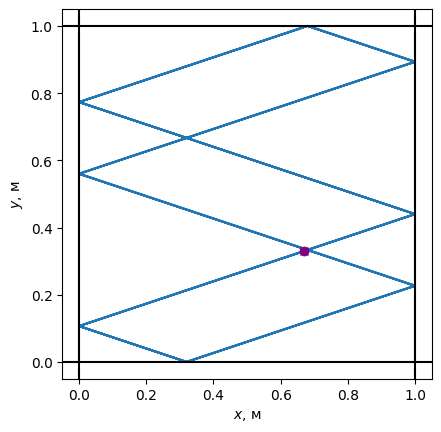

In [29]:
# Заметьте, мы уже не задаём шаг по времени
traj_des = de_solver(bounds, xy, v, t_until)
_, ax = plot_traj(traj_des)
ax.axvline(bounds[0], color="k")
ax.axvline(bounds[1], color="k")
ax.axhline(bounds[2], color="k")
ax.axhline(bounds[3], color="k")
ax.set(xlabel="$x$, м", ylabel="$y$, м", aspect="equal");
print("Число столкновений:", traj_des.shape[0] - 1)

Получили точное решение, которое заметно отличается от всех решений, полученных ранее - шарик оказался в том же самом месте, из которого начал своё движение.

Итак, приведём полученные результаты на одном графике:

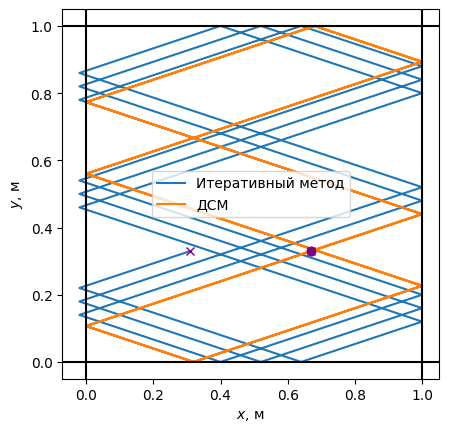

In [30]:
fig, ax = plot_traj(traj_iterative, label="Итеративный метод")
plot_traj(traj_des, (fig, ax), label="ДСМ")
ax.legend()

ax.axvline(bounds[0], color="k")
ax.axvline(bounds[1], color="k")
ax.axhline(bounds[2], color="k")
ax.axhline(bounds[3], color="k")
ax.set(xlabel="$x$, м", ylabel="$y$, м", aspect="equal");

Из полученного графика также отчётливо видно, как по мере увеличения числа событий, увеличивается ошибка итеративного метода.
С течением времени полученная с его помощью траектория всё сильнее и сильнее отклоняется от теоретической (оранжевой).

Изменим начальные условия и посмотрим на результат:

Число столкновений: 11


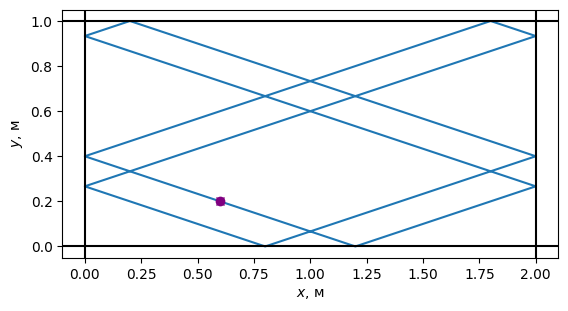

In [31]:
# Немного другие условия задачи
bounds = 0, 2, 0, 1
xy = 0.6, 0.2
v = 0.3, -0.1
t_until = 40    # ...равно периоду движения

traj = de_solver(bounds, xy, v, t_until)

# Показываем
_, ax = plot_traj(traj)
ax.axvline(bounds[0], color="k")
ax.axvline(bounds[1], color="k")
ax.axhline(bounds[2], color="k")
ax.axhline(bounds[3], color="k")
ax.set(xlabel="$x$, м", ylabel="$y$, м", aspect="equal");
print("Число столкновений:", traj.shape[0] - 1)

```{note}
Интересно подумать, почему получается периодическое движение и как рассчитать его период?
```

## Примеры использования SimPy

В данном разделе рассмотрены некоторые примеры из [официальной документации](https://simpy.readthedocs.io/en/latest/examples/index.html) SimPy с целью чуть лучше раскрыть принципы работы с данной библиотекой.

Прежде необходимо подключить SimPy:

```{code}
import simpy as sim
```

### Разочарование клиента в банке

Данный [пример](https://simpy.readthedocs.io/en/latest/examples/bank_renege.html) раскрывает такие возможности SimPy, как _ресурсы_ и _условные события_.

Задача следующая.
Есть банк, в который приходят клиенты.
У банка есть несколько окон для обслуживания клиентов.
Поток клиентов случаен.
Каждый клиент имеет определённое терпение, которое может закончиться, и клиент в результате просто уйдёт из банка.
Если же его очередь подойдёт быстрее, чем закончится терпение, то он подойдёт к окну и займёт его на некоторое время.
Остальные клиенты всё так же продолжат ждать своей очереди, насколько хватит терпения.

Нам точно понадобится рандом:

In [32]:
import random as rand

Также задаём основные параметры модели:

In [33]:
RANDOM_SEED = 42
NEW_CUSTOMERS = 5  # Общее число посетителей
INTERVAL_CUSTOMERS = 10.0  # Среднее время появления нового посетителя
MIN_PATIENCE = 1  # Минимальное
MAX_PATIENCE = 3  # и максимальное время ожидания клиента

Определим клиента как _функцию-процесс_ (в терминах SimPy) `customer`.
По сути своей, это обычная генераторная функция.

In [34]:
def customer(env, name, counter, time_in_bank):
    """Посетитель приходит, обслуживается и уходит."""
    arrive = env.now
    print(f"{arrive:7.4f} {name}: Я пришёл!")
    # Клиент "запрашивает" обслуживание, т.е. ресурс в терминах SimPy.
    # counter - это сотрудник банка (окно обслуживания).
    with counter.request() as req:
        # Каково же терпение!
        patience = rand.uniform(MIN_PATIENCE, MAX_PATIENCE)
        # Ожидание своей очереди, пока хватает терпения.
        # Это и есть условное событие: либо пришла очередь,
        # либо кончилось терпение. Оператор ИЛИ в yield-выражении
        # обозначается вертикальной чертой "|", как побитовое ИЛИ.
        results = yield req | env.timeout(patience)
        # Отмечаем, сколько клиент прождал
        wait = env.now - arrive
        # В results у нас список НАСТУПИВШИХ событий.
        # В данном случае могло наступить всего одно событие:
        # либо req, либо истекло время ожидания (timeout).
        if req in results:
            # Освободился ресурс (окно) - настала очередь клиента
            print(f"{env.now:7.4f} {name}: Прождал {wait:6.3f}")
            # Теперь клиент на случайное время занимает окно.
            # Всё это время ресурс req занят и не доступен
            # другим посетителям.
            tib = rand.expovariate(1.0 / time_in_bank)
            yield env.timeout(tib)
            print(f"{env.now:7.4f} {name}: Довольный ухожу")
        else:
            # Кончилось терпение!
            print(f"{env.now:7.4f} {name}: УХОЖУ после ожидания {wait:6.3f}!")

Теперь опишем генераторную функцию, ответственную за возникновение новых посетителей.
Назовём её `source`.
Она будет _процессом_ в терминах SimPy.

In [35]:
def source(env, number, interval, counter):
    """Случайным образом генерирует посетителей."""
    for i in range(number):
        c = customer(
            env,
            f"Посетитель с талончиком {i+1}",
            counter,
            time_in_bank=12.0
        )
        env.process(c)
        # Через сколько этот клиент нагрянет в банк?
        t = rand.expovariate(1.0 / interval)
        # Генерируем событие "Новый посетитель"
        yield env.timeout(t)

Теперь можно и моделировать:

In [36]:
# Настраиваем и запускаем симуляцию
print("Банковская идилия")
rand.seed(RANDOM_SEED)
env = sim.Environment()
# Запускаем процессы и прогонку (run) модели.
# - Окно обслуживания у нас всего одно и оно является ресурсом
#   в терминах SimPy.
counter = sim.Resource(env, capacity=1)
# - Инициализируем процесс появления клиентов, который, в свою очередь,
#   генерирует посетителя, запускает его как процесс, а потом ждёт,
#   прежде чем сгенерировать нового клиента.
env.process(source(env, NEW_CUSTOMERS, INTERVAL_CUSTOMERS, counter))
# - Так как всего будет NEW_CUSTOMERS посетителей, то симуляция
#   сама собой завершится, когда уйдёт последний клиент.
#   Поэтому нет нужды указывать run время моделирования until.
env.run()

Банковская идилия
 0.0000 Посетитель с талончиком 1: Я пришёл!
 0.0000 Посетитель с талончиком 1: Прождал  0.000
 3.8595 Посетитель с талончиком 1: Довольный ухожу
10.2006 Посетитель с талончиком 2: Я пришёл!
10.2006 Посетитель с талончиком 2: Прождал  0.000
12.7265 Посетитель с талончиком 3: Я пришёл!
13.9003 Посетитель с талончиком 3: УХОЖУ после ожидания  1.174!
23.7507 Посетитель с талончиком 2: Довольный ухожу
34.9993 Посетитель с талончиком 4: Я пришёл!
34.9993 Посетитель с талончиком 4: Прождал  0.000
37.9599 Посетитель с талончиком 4: Довольный ухожу
40.4798 Посетитель с талончиком 5: Я пришёл!
40.4798 Посетитель с талончиком 5: Прождал  0.000
43.1401 Посетитель с талончиком 5: Довольный ухожу


Вот и результат.
Не повезло лишь третьему талончику...
Ну и банку тоже! Вдруг именно этим клиентом был Илон Маск?

```{note}
Кстати, сравните полученный результат с результатом официального примера.
Абсолютно точное совпадение!
Всё из-за того, что использовалась одна и та же затравка `SEED` для генератора псевдослучайных чисел.
Ну и сам генератор был тем же самым - из стандартной библиотеки random.
```

Как видите, довольно просто и быстро можно смоделировать вполне реальную задачу [теории массового обслуживания](https://ru.wikipedia.org/wiki/Теория_массового_обслуживания).
Ведь никто не мешает учесть здесь финансовую сторону вопроса и прийти к оптимизационной задачи по типу: "Сколько нужно обслуживающих окон, чтобы минимизировать потерю клиентов, т.е. максимизировать прибыль?
Сколько нужно окон утром во вторник и вечером пятницы?
Как при этом минимизировать затраты на новых сотрудников, но не ухудшить обслуживание?
Поставить автоматы самообслуживания?
Сколько их нужно?
Когда и сколько денег в них загружать?"
Ну вы поняли...

```{important}
Создаётся впечатление, будто процессы `source` и `customer` выполняются параллельно.
На самом деле это _не совсем_ так.

С точки зрения операционной системы _поток выполнения_ нашей программы один, т.е. программа не "выполняется на нескольких ядрах".
Иными словами, параллелизма _на аппаратном уровне_ здесь нет.

Но есть параллелизм на уровне программы.
Генераторы лежат в основе [асинхронного программирования](https://ru.wikipedia.org/wiki/Асинхронное_программирование), при котором отдельные части программы могут работать асинхронно, т.е. не ожидать завершения друг друга.
Подробнее основы асинхронного программирования изложены [здесь](https://proglib.io/p/asynchrony?ysclid=lmjk2v8cxv779630081).

У нас может быть **любое** количество запущенных процессов, но каждый процесс - это генератор.
А генератор ничего не делает, пока к нему не будет применена стандартная функция `next`.
Эту функцию среды `env` начинает применяет к генераторам наш объект, когда мы запускаем симуляцию методом `run`.

К какому именно генератору из всего множества имеющихся применить `next`?
Среда `env` определяет это, исходя из своего _журнала событий_, который она непрерывно ведёт.
Например, когда мы написали внутри процесса `source` выражение `yield env.timeout(t)`, то объект `env` "под капотом" добавил в журнал событие типа [`Timeout`](https://simpy.readthedocs.io/en/latest/api_reference/simpy.events.html#simpy.events.Timeout), которое произойдёт во время `env.now + t`.
Когда это событие является следующим в очереди, то определяется генератор, к которому оно принадлежит (опять же SimPy сопоставляет процессы с событиями "под капотом"), и к этому генератору применяется `next`.
Никакой "магии" не происходит - только чистые Python-генераторы!
```